# Summary

# Trying out some stuff

## A simple univariate case

From ChatGPT:

**Background**: A local hospital is trying to understand factors that might influence the recovery speed (measured as the number of days spent in the hospital) after undergoing a specific surgery. The surgical procedure is common and is performed on both patients who are smokers and those who are non-smokers. Moreover, patients have the option of undergoing either a traditional surgical method or a newer, minimally invasive method.

**Research Question**: Does smoking status and the type of surgical method influence the recovery time of patients?

**Binary Variables**:

- Smoking Status:

    - 0: Non-Smoker
    - 1: Smoker

- Surgical Method:

    - 0: Traditional Surgery    
    - 1: Minimally Invasive Surgery (new surgery)

**Outcome Variable**: Recovery time: A continuous variable representing the number of days a patient spends in the hospital post-surgery.

**Data Collection**:
The hospital collects data over a year from patients who underwent the procedure, noting down their smoking status, the type of surgical method, and their recovery time.

**Regression Story**:
- Smokers who undergo traditional surgery have a significantly longer recovery time compared to non-smokers who undergo the same traditional method. This could be due to the overall decreased lung efficiency and increased risk of post-surgical complications in smokers.

- However, when opting for the minimally invasive method, the difference in recovery time between smokers and non-smokers narrows down. The minimally invasive procedure, being less taxing on the body, might be reducing the impact of smoking on recovery.

- On its own, the minimally invasive surgery results in faster recovery times compared to the traditional method for both smokers and non-smokers. Yet, the advantage of the minimally invasive method seems even more pronounced for smokers, making it a favorable option for this group.

**Conclusion**:
The hospital might consider recommending the minimally invasive surgical method, especially for smokers, to ensure faster recovery times. Additionally, pre-surgical counseling for smokers about the risks and benefits associated with each method could be beneficial.

In [1]:
library(data.table)
library(PSweight)
library(ggplot2)

In [2]:
N <- 200      ## nb of patients in each group
p_s <- 0.75   ## pct smokers in treatment group

In [3]:
## 75% percent smoker in the test group, 25% in the control group:
ex1 <- data.table(test=rep(c(TRUE, FALSE), each=N), 
                  smoker=c(as.logical(rbinom(N, 1, p_s)), as.logical(rbinom(N, 1, 1 - p_s))))
print(ex1)

      test smoker
  1:  TRUE   TRUE
  2:  TRUE   TRUE
  3:  TRUE   TRUE
  4:  TRUE   TRUE
  5:  TRUE   TRUE
 ---             
396: FALSE  FALSE
397: FALSE  FALSE
398: FALSE  FALSE
399: FALSE  FALSE
400: FALSE  FALSE


In [4]:
# smokers have mean 60 days recovery, non-smokers 30 days
ex1[smoker==TRUE, recovery := rnorm(sum(ex1$smoker), 60, 6)]
ex1[smoker==FALSE, recovery := rnorm(sum(!ex1$smoker), 30, 3)]
print(ex1, topn=10)

      test smoker recovery
  1:  TRUE   TRUE 58.58667
  2:  TRUE   TRUE 58.71050
  3:  TRUE   TRUE 61.33384
  4:  TRUE   TRUE 56.87212
  5:  TRUE   TRUE 47.68802
  6:  TRUE   TRUE 61.95357
  7:  TRUE  FALSE 28.61793
  8:  TRUE   TRUE 58.57371
  9:  TRUE   TRUE 66.45484
 10:  TRUE   TRUE 64.87744
 ---                      
391: FALSE  FALSE 22.95629
392: FALSE   TRUE 47.49311
393: FALSE  FALSE 32.28439
394: FALSE  FALSE 29.16974
395: FALSE  FALSE 24.61460
396: FALSE  FALSE 34.86637
397: FALSE  FALSE 27.09078
398: FALSE  FALSE 32.29617
399: FALSE  FALSE 29.48396
400: FALSE  FALSE 29.24557


In [5]:
logistic_model <- glm("test ~ smoker", family=binomial, data=ex1)
summary(logistic_model)


Call:
glm(formula = "test ~ smoker", family = binomial, data = ex1)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.69296  -0.75202  -0.00684   0.73833   1.67403  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.1184     0.1629  -6.866 6.62e-12 ***
smokerTRUE    2.2789     0.2334   9.764  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 443.12  on 398  degrees of freedom
AIC: 447.12

Number of Fisher Scoring iterations: 4


In [6]:
## get the probabilities of belonging to the treatment group, the propensity:
ex1[, propensity := predict(logistic_model, ex1[, .(smoker)], type="response")]
print(ex1, topn=10)

      test smoker recovery propensity
  1:  TRUE   TRUE 58.58667  0.7614213
  2:  TRUE   TRUE 58.71050  0.7614213
  3:  TRUE   TRUE 61.33384  0.7614213
  4:  TRUE   TRUE 56.87212  0.7614213
  5:  TRUE   TRUE 47.68802  0.7614213
  6:  TRUE   TRUE 61.95357  0.7614213
  7:  TRUE  FALSE 28.61793  0.2463054
  8:  TRUE   TRUE 58.57371  0.7614213
  9:  TRUE   TRUE 66.45484  0.7614213
 10:  TRUE   TRUE 64.87744  0.7614213
 ---                                 
391: FALSE  FALSE 22.95629  0.2463054
392: FALSE   TRUE 47.49311  0.7614213
393: FALSE  FALSE 32.28439  0.2463054
394: FALSE  FALSE 29.16974  0.2463054
395: FALSE  FALSE 24.61460  0.2463054
396: FALSE  FALSE 34.86637  0.2463054
397: FALSE  FALSE 27.09078  0.2463054
398: FALSE  FALSE 32.29617  0.2463054
399: FALSE  FALSE 29.48396  0.2463054
400: FALSE  FALSE 29.24557  0.2463054


In [7]:
## now calculate the weights:
ex1[test==TRUE, weight := 1 / propensity]
ex1[test==FALSE, weight := 1 / (1 - propensity)]
print(ex1, topn=10)

      test smoker recovery propensity   weight
  1:  TRUE   TRUE 58.58667  0.7614213 1.313333
  2:  TRUE   TRUE 58.71050  0.7614213 1.313333
  3:  TRUE   TRUE 61.33384  0.7614213 1.313333
  4:  TRUE   TRUE 56.87212  0.7614213 1.313333
  5:  TRUE   TRUE 47.68802  0.7614213 1.313333
  6:  TRUE   TRUE 61.95357  0.7614213 1.313333
  7:  TRUE  FALSE 28.61793  0.2463054 4.060000
  8:  TRUE   TRUE 58.57371  0.7614213 1.313333
  9:  TRUE   TRUE 66.45484  0.7614213 1.313333
 10:  TRUE   TRUE 64.87744  0.7614213 1.313333
 ---                                          
391: FALSE  FALSE 22.95629  0.2463054 1.326797
392: FALSE   TRUE 47.49311  0.7614213 4.191489
393: FALSE  FALSE 32.28439  0.2463054 1.326797
394: FALSE  FALSE 29.16974  0.2463054 1.326797
395: FALSE  FALSE 24.61460  0.2463054 1.326797
396: FALSE  FALSE 34.86637  0.2463054 1.326797
397: FALSE  FALSE 27.09078  0.2463054 1.326797
398: FALSE  FALSE 32.29617  0.2463054 1.326797
399: FALSE  FALSE 29.48396  0.2463054 1.326797
400: FALSE  F

In [8]:
print(sum(ex1[test==TRUE ]$smoker)    / nrow(ex1[test==TRUE]))
print(sum(ex1[test==FALSE]$smoker)    / nrow(ex1[test==FALSE]))
print(sum(ex1[test  & smoker]$weight) / sum(ex1[test==TRUE]$weight))
print(sum(ex1[!test & smoker]$weight) / sum(ex1[test==FALSE]$weight))

[1] 0.75
[1] 0.235
[1] 0.4925
[1] 0.4925


Without the propensity weights, we see that the difference between test and control group is significant:

In [9]:
summary(aov(recovery ~ test, data=ex1))

             Df Sum Sq Mean Sq F value Pr(>F)    
test          1  24468   24468   128.4 <2e-16 ***
Residuals   398  75829     191                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

But when we use the weights, we see that this difference is not significant, because it is entirely explained by the higher percentage of smokers in the test group, which is "matched" out when we use the weights:

In [10]:
summary(aov(recovery ~ test, data=ex1, weights=ex1$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1      2     2.5   0.005  0.944
Residuals   398 200387   503.5               

### Checking with PSweight

In [11]:
ipw <- PSweight(test ~ smoker, data=ex1, yname="recovery", weight="IPW")
print(summary(ipw))
ipw


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error      lwr    upr Pr(>|z|)
Contrast 1  0.11129   0.57141 -1.00864 1.2312   0.8456


Original group value:  FALSE, TRUE 

Point estimate: 
44.4585, 44.5698 

In [12]:
summary(ipw)


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error      lwr    upr Pr(>|z|)
Contrast 1  0.11129   0.57141 -1.00864 1.2312   0.8456

## Problems

### Missing propensity variable

### Small divisors

We introduce a new covariate `new_surgery`. In the test group, we assign all smokers to new_surgery and all non-smokers to non-new_surgerys; in the control group, we assign the new_surgerys randomly to the whole population with the same probability as the probability of being smoker in the control group (0.75).

In [13]:
ex2 <- copy(ex1)
ex2[test==TRUE, new_surgery := smoker]
#ex2[test & smoker, new_surgery := rbinom(nrow(ex2[test & smoker]), 1, 0.9)]
#ex2[test & !smoker, new_surgery := rbinom(nrow(ex2[test & !smoker]), 1, 0.1)]
ex2[test==FALSE, new_surgery := rbinom(nrow(ex2[test==FALSE]), 1, p_s)]

In [14]:
## percent smoker new_surgerys:
nrow(ex2[test & smoker & new_surgery])/nrow(ex2[test & smoker])

[1] 1

In [15]:
## percent male new_surgerys:
nrow(ex2[test & !smoker & new_surgery])/nrow(ex2[test & !smoker])

[1] 0

In [16]:
logistic_model <- glm("test ~ smoker + new_surgery", family=binomial, data=ex2)
summary(logistic_model)


Call:
glm(formula = "test ~ smoker + new_surgery", family = binomial, 
    data = ex2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5518  -0.4477   0.1568   0.7613   1.2305  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.1239     0.2190  -0.566    0.572    
smokerTRUE        3.3403     0.3437   9.719  < 2e-16 ***
new_surgeryTRUE  -2.1261     0.3689  -5.762 8.29e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 399  degrees of freedom
Residual deviance: 402.14  on 397  degrees of freedom
AIC: 408.14

Number of Fisher Scoring iterations: 5


In [17]:
ex2[, propensity := predict(logistic_model, ex2, type="response")]
ex2[test==TRUE, weight := 1 / propensity]
ex2[test==FALSE, weight := 1 / (1 - propensity)]
print(ex2, topn=10)

      test smoker recovery propensity   weight new_surgery
  1:  TRUE   TRUE 58.58667 0.74844668 1.336101        TRUE
  2:  TRUE   TRUE 58.71050 0.74844668 1.336101        TRUE
  3:  TRUE   TRUE 61.33384 0.74844668 1.336101        TRUE
  4:  TRUE   TRUE 56.87212 0.74844668 1.336101        TRUE
  5:  TRUE   TRUE 47.68802 0.74844668 1.336101        TRUE
  6:  TRUE   TRUE 61.95357 0.74844668 1.336101        TRUE
  7:  TRUE  FALSE 28.61793 0.46905654 2.131939       FALSE
  8:  TRUE   TRUE 58.57371 0.74844668 1.336101        TRUE
  9:  TRUE   TRUE 66.45484 0.74844668 1.336101        TRUE
 10:  TRUE   TRUE 64.87744 0.74844668 1.336101        TRUE
 ---                                                      
391: FALSE  FALSE 22.95629 0.09535011 1.105400        TRUE
392: FALSE   TRUE 47.49311 0.74844668 3.975300        TRUE
393: FALSE  FALSE 32.28439 0.09535011 1.105400        TRUE
394: FALSE  FALSE 29.16974 0.09535011 1.105400        TRUE
395: FALSE  FALSE 24.61460 0.09535011 1.105400        TR

In [18]:
summary(aov(recovery ~ test, data=ex2))

             Df Sum Sq Mean Sq F value Pr(>F)    
test          1  24468   24468   128.4 <2e-16 ***
Residuals   398  75829     191                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [19]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

             Df Sum Sq Mean Sq F value Pr(>F)
test          1    598   598.5   1.072  0.301
Residuals   398 222232   558.4               

In [20]:
print(sum(ex2[test==TRUE]$smoker)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$smoker)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  smoker]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & smoker]$weight)/sum(ex2[test==FALSE]$weight))

[1] 0.75
[1] 0.235
[1] 0.6527923
[1] 0.6989171


In [21]:
print(sum(ex2[test==TRUE]$new_surgery)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$new_surgery)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  new_surgery]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & new_surgery]$weight)/sum(ex2[test==FALSE]$weight))

[1] 0.75
[1] 0.78
[1] 0.6527923
[1] 0.4234652


Now let's imagine new_surgery has an effect, if you're a new_surgery, you're 15 recovery lighter:

In [22]:
ex2[new_surgery==TRUE, recovery := recovery + 50]

In [23]:
summary(aov(recovery ~ test, data=ex2))

             Df Sum Sq Mean Sq F value  Pr(>F)    
test          1  20001   20001   21.98 3.8e-06 ***
Residuals   398 362198     910                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

We find then with these weights that the test group is significantly different from the control group, which we know by design of this simulation is not true:

In [24]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

             Df Sum Sq Mean Sq F value  Pr(>F)   
test          1  19848   19848   9.564 0.00212 **
Residuals   398 826004    2075                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Running PSweight

In [25]:
ipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW")
print(ipw)
summary(ipw)

Original group value:  FALSE, TRUE 

Point estimate: 
72.3218, 82.0917 



Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error    lwr    upr Pr(>|z|)   
Contrast 1   9.7699    3.0556 3.7811 15.759 0.001387 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [26]:
ipw_ss <- SumStat(test ~ smoker + new_surgery, data=ex2, weight="IPW")
summary(ipw_ss)

unweighted result
                Mean FALSE Mean TRUE   SMD
smokerTRUE           0.235      0.75 1.199
new_surgeryTRUE      0.780      0.75 0.071

IPW result
                Mean FALSE Mean TRUE   SMD
smokerTRUE           0.699     0.653 0.107
new_surgeryTRUE      0.423     0.653 0.540


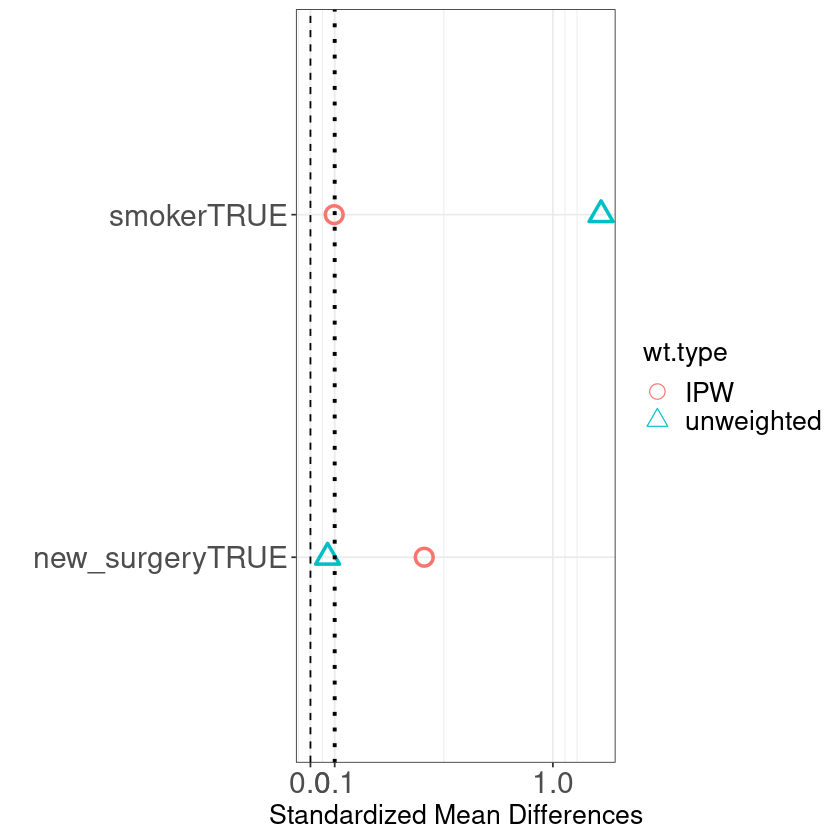

In [27]:
plot(ipw_ss)

In [28]:
aipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW", 
                augmentation = TRUE, out.formula = recovery ~ smoker + new_surgery)
summary(ipw)

Warning message in predict.lm(fitglm, type = "response", dataout):
“prediction from a rank-deficient fit may be misleading”



Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error    lwr    upr Pr(>|z|)   
Contrast 1   9.7699    3.0556 3.7811 15.759 0.001387 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# AIPW

Let's examine the Augmented Inverse Propensity Weighting. We start by simulating a simple treatment/control group with a couple of covariates.

$$Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon$$

To add some realism, we'll have our treatment have a different range of X and fix $\beta$ and $\tau$.

$$X_{treat} \sim Normal(\mu=4, \sigma=1)$$
$$X_{cntl} \sim Normal(\mu=6, \sigma=1)$$
$$\beta = 2$$
$$\tau = 1$$
$$\epsilon \sim Normal(\mu=0.2, \sigma=1)$$

In [53]:
sz <- 100
beta1 <- 2
tau <- 1
mu_epsilon <- 0.1
dt <- data.table(x1=c(rnorm(sz, 4, 1), rnorm(sz, 6, 1)), 
                 W=c(rep(1, sz), rep(0, sz)),
                 epsilon=rnorm(sz*2, mu_epsilon, 1))
dt[, y := x1 * beta1 + W * tau + epsilon]
print(summary(dt[W==1]))
print(summary(dt[W==0]))

       x1              W        epsilon              y         
 Min.   :1.525   Min.   :1   Min.   :-2.3165   Min.   : 2.934  
 1st Qu.:3.378   1st Qu.:1   1st Qu.:-0.6751   1st Qu.: 7.508  
 Median :4.080   Median :1   Median : 0.1183   Median : 8.985  
 Mean   :3.974   Mean   :1   Mean   : 0.1141   Mean   : 9.063  
 3rd Qu.:4.624   3rd Qu.:1   3rd Qu.: 0.9632   3rd Qu.:10.523  
 Max.   :7.026   Max.   :1   Max.   : 2.4880   Max.   :15.546  
       x1              W        epsilon              y         
 Min.   :3.784   Min.   :0   Min.   :-2.5310   Min.   : 7.781  
 1st Qu.:5.430   1st Qu.:0   1st Qu.:-0.4250   1st Qu.:11.073  
 Median :6.191   Median :0   Median : 0.3478   Median :12.492  
 Mean   :6.140   Mean   :0   Mean   : 0.3244   Mean   :12.603  
 3rd Qu.:6.797   3rd Qu.:0   3rd Qu.: 1.1371   3rd Qu.:13.868  
 Max.   :8.629   Max.   :0   Max.   : 2.8036   Max.   :18.909  


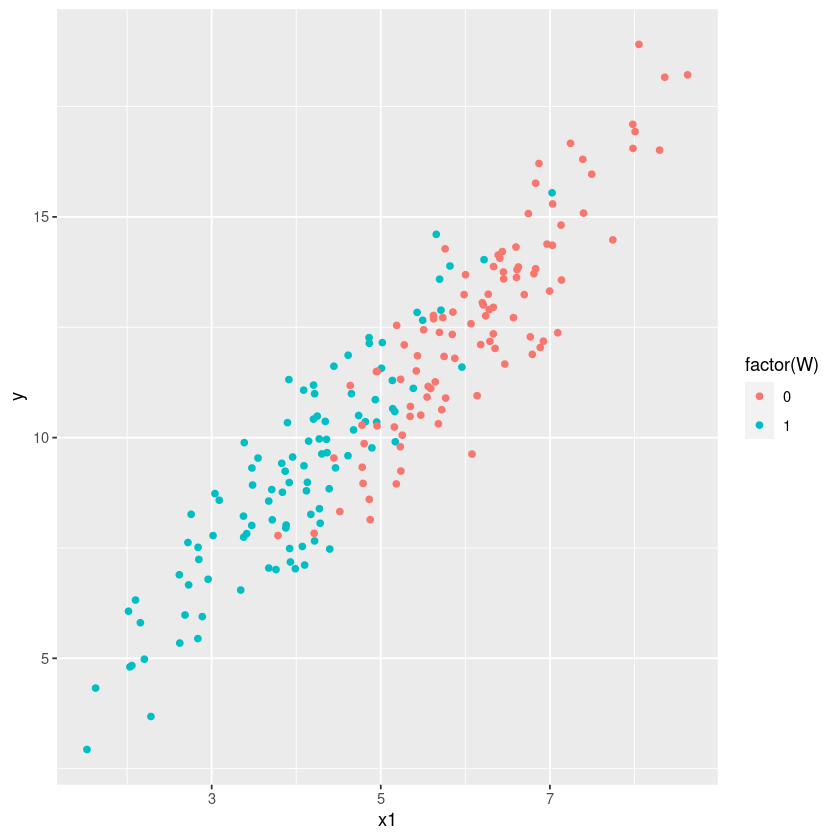

In [54]:
ggplot(dt, aes(x1, y, color=factor(W))) +
    geom_point()

## IPW

First we use a logistic regression to figure out the propensity score *e(i)*

In [55]:
propensity_model <- glm(W ~ x1, data=dt, family=binomial)
summary(propensity_model)


Call:
glm(formula = W ~ x1, family = binomial, data = dt)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.41902  -0.39186   0.00031   0.45470   2.96575  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  11.3408     1.6015   7.081 1.43e-12 ***
x1           -2.2384     0.3132  -7.148 8.83e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 277.26  on 199  degrees of freedom
Residual deviance: 127.42  on 198  degrees of freedom
AIC: 131.42

Number of Fisher Scoring iterations: 6


In [56]:
dt[, e := predict(propensity_model, data=dt, type="response")]
print(dt)

           x1 W     epsilon         y           e
  1: 3.760527 1 -1.51072213  7.010332 0.948987182
  2: 4.445453 1  1.72636152 11.617267 0.800623171
  3: 3.836554 1  0.08884246  8.761951 0.940090432
  4: 5.141196 1 -0.62732018 10.655072 0.458310651
  5: 4.272064 1  0.42563609  9.969764 0.855487248
 ---                                             
196: 6.351417 0 -0.68181245 12.021021 0.053348771
197: 6.453167 0  0.68887782 13.595212 0.042949338
198: 7.980397 0  1.13695096 17.097744 0.001468042
199: 6.811135 0  0.09159354 13.713863 0.019741314
200: 6.627745 0  0.61078866 13.866279 0.029466047


And now we can estimate the propensity weighted means and see what $\tau$ we get:

In [57]:
mu1 <- sum(dt$W * dt$y / dt$e) / sum(dt$W / dt$e)
mu0 <- sum((1-dt$W) * dt$y / (1-dt$e)) / sum((1 - dt$W) / (1 - dt$e))
cat(paste("mu1:", mu1, "\n"))
cat(paste("mu0:", mu0, "\n"))
ATE_prop <- mu1 - mu0
print(ATE_prop)

mu1: 12.0711781219342 
mu0: 11.3319464568447 
[1] 0.7392317


So it's fair to say we've done a reasonable job of estimating tau.

## Regression

Now let's look at a second way of approching the problem. Here we estimate directly $\mu_{0}$
and $\mu_{1}$ from the treatment and control groups, conditional on X.

Note the regression is conducted separately on the two groups. It is not:

$$Y \sim X\beta + W\tau + \epsilon$$

but instead:

$$Y_{1} \sim X_{1}\beta_{1} + \epsilon$$
$$Y_{0} \sim X_{0}\beta_{1} + \epsilon$$

"We emphasize that, throughout our analysis, we defined the target estimand τ = E [∆i] before making any modeling assumptions. Linear modeling was only used as a tool to estimate τ , but did not inform the scientific question we tried to answer. In particular, we did not try to estimate τ by direct regression modeling $Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon_{i}$, while claiming that the coefficient on τ is a causal effect. This approach has the vice of tying our scientific question to our regression modeling strategy: τ appears to just have become a coefficient in our linear model, not a fact of nature that’s conceptually prior to modeling decisions." (https://web.stanford.edu/~swager/stats361.pdf, page 8).

In [58]:
model_mu1 <- lm(y ~ x1, data=dt[W==1])
summary(model_mu1)


Call:
lm(formula = y ~ x1, data = dt[W == 1])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.44943 -0.83585  0.04776  0.81468  2.37669 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.9360     0.4289   2.182   0.0315 *  
x1            2.0448     0.1043  19.603   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.101 on 98 degrees of freedom
Multiple R-squared:  0.7968,	Adjusted R-squared:  0.7947 
F-statistic: 384.3 on 1 and 98 DF,  p-value: < 2.2e-16


In [59]:
model_mu0 <- lm(y ~ x1, data=dt[W==0])
summary(model_mu0)


Call:
lm(formula = y ~ x1, data = dt[W == 0])

Residuals:
     Min       1Q   Median       3Q      Max 
-2.84719 -0.67754  0.05041  0.76461  2.48350 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.5134     0.6915  -0.742     0.46    
x1            2.1365     0.1112  19.208   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.088 on 98 degrees of freedom
Multiple R-squared:  0.7901,	Adjusted R-squared:  0.788 
F-statistic:   369 on 1 and 98 DF,  p-value: < 2.2e-16


Now we've got our models for $\mu_{1}$, $\mu_{0}$, we evaluate them conditional on all X:

In [60]:
ATE_reg <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt))
ATE_reg

[1] 0.9858605

## IPW + regression = AIPW

We now use both the IPW and the regression to get the Augmented IPW; for this, the idea is to calculate mu0 and mu1, and then to use the IPW on the residuals of the regression instead of directly on the Y.

In [61]:
ATE_aipw <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt) + 
                             dt$W * (dt$y - predict(model_mu1, dt)) / dt$e -
                             (1-dt$W) * (dt$y - predict(model_mu0, dt)) / (1-dt$e))
ATE_aipw

[1] 1.123912

## Let's get some confirmation using the package PSweight

In [62]:
ipw <- PSweight(W ~ x1, data=dt, yname="y", weight="IPW")
ipw$muhat["1"] - ipw$muhat["0"]

1 
0.7392317

In [63]:
aug = PSweight(W ~ x1, data=dt, yname="y", weight="IPW", augmentation = TRUE, out.formula = y ~ x1)
aug$muhat["1"] - aug$muhat["0"]

1 
1.095381